In [4]:
import pymysql
import pandas as pd

In [5]:
# Database connection details
db_config = {
    "host": "localhost",  # Change to your database host
    "user": "root",       # Change to your database username
    "password": "root123",  # Change to your database password
    "database": "sales"  # Change to your database name
}

In [6]:
df_od = pd.read_csv("order_detail.csv")
df_sd = pd.read_csv("sku_detail.csv")
df_pd = pd.read_csv("payment_detail.csv")
df_cd = pd.read_csv("customer_detail.csv")

In [7]:
# Merge the dataframes
# Before merge we need to rename column in order to avoid duplicate column value
# So the key column will be excluded when joined
df_sd.rename(columns={'id':'sku_id'}, inplace=True)
df_cd.rename(columns={'id':'customer_id'}, inplace=True)
df_pd.rename(columns={'id':'payment_id'}, inplace=True)

In [8]:
# Merge the dataframes using left join
df = pd.DataFrame(df_od\
                  # Merge order_detail with sku_detail on column sku_id
                  .merge(df_sd, how='left', on='sku_id')\
                  # Merge the result to customer_detail on column customer_id
                  .merge(df_cd, how='left', on='customer_id')\
                  # Merge the result to payment_detail on column payment_id
                  .merge(df_pd, how='left', on='payment_id')
                  )

In [9]:
# Ensure both columns have the same data type before merging
df_pd['payment_id'] = df_pd['payment_id'].astype(str)  # Convert to string
df_od['id'] = df_od['id'].astype(str)                  # Convert to string

# Merge order_detail with payment_detail without renaming columns
df_sample = pd.merge(df_pd, df_od, how='left', left_on='payment_id', right_on='id')

# Display info about the resulting DataFrame
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   payment_id_x     16 non-null     object 
 1   payment_method   16 non-null     object 
 2   id               0 non-null      object 
 3   customer_id      0 non-null      object 
 4   order_date       0 non-null      object 
 5   sku_id           0 non-null      object 
 6   price            0 non-null      float64
 7   qty_ordered      0 non-null      float64
 8   before_discount  0 non-null      float64
 9   discount_amount  0 non-null      float64
 10  after_discount   0 non-null      float64
 11  is_gross         0 non-null      float64
 12  is_valid         0 non-null      float64
 13  is_net           0 non-null      float64
 14  payment_id_y     0 non-null      float64
dtypes: float64(9), object(6)
memory usage: 2.0+ KB


In [10]:
# change columns to datetime format using for loop
# use pandas.to_datetime to convert
for x in ['order_date', 'registered_date']:
  df[x] = pd.to_datetime(df[x])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               11528 non-null  object        
 1   customer_id      11528 non-null  object        
 2   order_date       11528 non-null  datetime64[ns]
 3   sku_id           11528 non-null  object        
 4   price            11528 non-null  int64         
 5   qty_ordered      11528 non-null  int64         
 6   before_discount  11528 non-null  float64       
 7   discount_amount  11528 non-null  float64       
 8   after_discount   11528 non-null  float64       
 9   is_gross         11528 non-null  int64         
 10  is_valid         11528 non-null  int64         
 11  is_net           11528 non-null  int64         
 12  payment_id       11528 non-null  int64         
 13  sku_name         11528 non-null  object        
 14  base_price       11528 non-null  float

In [11]:
"""Question 1: 
Top 5 Products by Sales in 2022 for the "Mobiles & Tablets" Category Scenario: 
The Marketing Team is preparing for a Year-End Festival and needs to identify the top 5 products in the "Mobiles & Tablets" category that had the highest sales quantities in 2022. The products should be filtered to ensure only valid orders are included.
 Requirements: • Filter the data to include only products from the "Mobiles & Tablets" category in 2022, where the is_valid feature is set to 1.
 • Group the data by sku_name and category, and sum the qty_ordered for each product.
 • Rank the products based on their total sales quantity in descending order.
 • Display the top 5 products with the highest sales quantities. 
• Generate a horizontal bar chart showing the top 5 products by quantity. 
Key Features to Use: • category • order_date (for filtering by year) • is_valid (to filter valid orders) • sku_name (for product names) • qty_ordered (for sales quantities)
"""


'Question 1: \nTop 5 Products by Sales in 2022 for the "Mobiles & Tablets" Category Scenario: \nThe Marketing Team is preparing for a Year-End Festival and needs to identify the top 5 products in the "Mobiles & Tablets" category that had the highest sales quantities in 2022. The products should be filtered to ensure only valid orders are included.\n Requirements: • Filter the data to include only products from the "Mobiles & Tablets" category in 2022, where the is_valid feature is set to 1.\n • Group the data by sku_name and category, and sum the qty_ordered for each product.\n • Rank the products based on their total sales quantity in descending order.\n • Display the top 5 products with the highest sales quantities. \n• Generate a horizontal bar chart showing the top 5 products by quantity. \nKey Features to Use: • category • order_date (for filtering by year) • is_valid (to filter valid orders) • sku_name (for product names) • qty_ordered (for sales quantities)\n'

In [151]:
Top_5_products = pd.DataFrame(\
                          # filter the columns as needed
                          df[(df['category']=='Mobiles & Tablets') & (df['is_valid']==1) & (df['order_date'].dt.year == 2022)]\
                          # aggregate using groupby method
                          .groupby(by=['sku_name','category'])['qty_ordered'].sum()\
                          # reset the index to convert result into dataframe
                          .reset_index(name='qty_ordered')\
                         #renaming the columns
                         .rename(columns={
                                            'sku_name': 'Product_Name',
                                            'category': 'Category',
                                            'qty_ordered':'Sales_Quantity'
                                          }
                                )
                          # sort the value from the largest to the lowest
                          .sort_values(by='Sales_Quantity', ascending=False)\
                          # select top 5 row
                          .head(5).reset_index(drop=True)
                          )
Top_5_products

,Product_Name,Category,Sales_Quantity
0,IDROID_BALRX7-Gold,Mobiles & Tablets,2000
1,IDROID_BALRX7-Jet black,Mobiles & Tablets,62
2,Infinix Hot 4-Gold,Mobiles & Tablets,30
3,samsung_Grand Prime Plus-Black,Mobiles & Tablets,22
4,infinix_Zero 4-Grey,Mobiles & Tablets,20


<Axes: title={'center': 'TOP 5 Products'}, xlabel='Product Name', ylabel='Sales Quantity'>

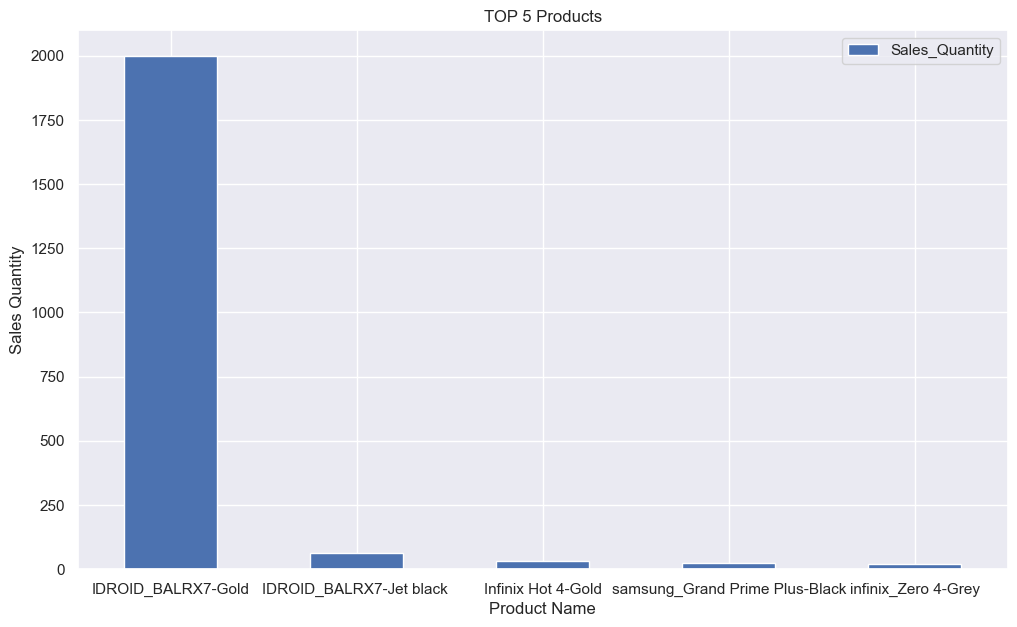

In [181]:
# show the chart
import seaborn as sns

top_5_prod.sort_values(by='Sales_Quantity', ascending=False, inplace=True)

# plot
sns.set()
top_5_prod.plot(x='Product_Name',
           y=['Sales_Quantity'],
           kind='bar',
           grid = True,
           xlabel = 'Product Name',
           ylabel = 'Sales Quantity',
           figsize=(12,7),
           rot = 0,
           title = 'TOP 5 Products',
           table = False,
           secondary_y = False)

In [14]:
"""Question 2
Analyzing Sales Decrease in the "Others" Category Between 2021 and 2022 Scenario: 
The Warehouse Team has observed a surplus in the stock of "Others" category products at the end of 2022. 
They would like to know if sales have declined in 2022 compared to 2021. 
Additionally, they want to see the 20 products that experienced the largest decrease in sales.
 Requirements: 1. Create two datasets: o One for sales data in 2021 (qty_ordered for "Others" category).
                                       o One for sales data in 2022 (qty_ordered for "Others" category).
 2. Merge the datasets and calculate the sales difference between 2022 and 2021. 
 3. Calculate the percentage change in sales and classify it as "DOWN", "UP", or "FAIR".
 4. Sort the products by the largest decrease in sales and show the top 20 products. 
 5. Create a horizontal bar chart to display the products with the largest decrease in sales between 2022 and 2021.
 Key Features to Use: • category • order_date (for filtering by year) • is_valid • sku_name • qty_ordered*."""


'Question 2\nAnalyzing Sales Decrease in the "Others" Category Between 2021 and 2022 Scenario: \nThe Warehouse Team has observed a surplus in the stock of "Others" category products at the end of 2022. \nThey would like to know if sales have declined in 2022 compared to 2021. \nAdditionally, they want to see the 20 products that experienced the largest decrease in sales.\n Requirements: 1. Create two datasets: o One for sales data in 2021 (qty_ordered for "Others" category).\n                                       o One for sales data in 2022 (qty_ordered for "Others" category).\n 2. Merge the datasets and calculate the sales difference between 2022 and 2021. \n 3. Calculate the percentage change in sales and classify it as "DOWN", "UP", or "FAIR".\n 4. Sort the products by the largest decrease in sales and show the top 20 products. \n 5. Create a horizontal bar chart to display the products with the largest decrease in sales between 2022 and 2021.\n Key Features to Use: • category • o

In [163]:
data_2021 = pd.DataFrame(\
                    
                         
                           # filter is_valid = 1 and year 2021
                          df[ (df['category']== 'Others') & (df['is_valid']==1) & (df['order_date'].dt.year == 2021)]\
                           # groupby quantity
                           .groupby(by=['category','sku_name'])['qty_ordered'].sum()\

                           # convert to dataframe
                           .reset_index(name='Sales_2021')
        .rename(columns={'qty_ordered': 'Sales_2021',
                     'sku_name': 'Product_Name'})
        .sort_values(by='Sales_2021', ascending=False)\
                           )


data_2022 = pd.DataFrame(\
                    
                         
                           # filter is_valid = 1 and year 2022
                          df[ (df['category']== 'Others') & (df['is_valid']==1) & (df['order_date'].dt.year == 2022)]\
                           # groupby quantity
                           .groupby(by=['category','sku_name'])['qty_ordered'].sum()\

                           # convert to dataframe
                           .reset_index(name='Sales_2022')
        .rename(columns={'qty_ordered': 'Sales_2022',
                     'sku_name': 'Product_Name'})
        .sort_values(by='Sales_2022', ascending=False)\
                           )
# join those 2 dataframes
data_2021_2022 = data_2021.merge(data_2022[['Product_Name', 'Sales_2022']], how='outer')

# show
data_2021_2022


,category,Product_Name,Sales_2021,Sales_2022
0,NaN,AL Khair_Baby Oil 50ml,NaN,2.0
1,Others,Aladdin_Wrench_Snap N Grip_01,2.0,NaN
2,Others,Aladdin_bike_cover,6.0,4.0
3,NaN,Alerashine_sku-09-XL,NaN,2.0
4,Others,Am-PTV_ATS-004-M,10.0,NaN
...,...,...,...,...
157,Others,stripyinterior_100006,2.0,NaN
158,NaN,sukoonbundle-sukoon10-cj_CJPOISL,NaN,2.0
159,NaN,test-product-00,NaN,2.0
160,Others,tucano_IPD7AN-BK,2.0,NaN


In [164]:
# fill "NaN" with "Others" in column "category"
data_2021_2022['category'].fillna('Others', inplace=True)

# fill the rest "NaN" with 0
data_2021_2022.fillna(0, inplace=True)

# add column delta_2022_2021
data_2021_2022['Sales_Diff'] = data_2021_2022['Sales_2022'] - data_2021_2022['Sales_2021']
# show the data
data_2021_2022


C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_27588\328241963.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_2021_2022['category'].fillna('Others', inplace=True)


,category,Product_Name,Sales_2021,Sales_2022,Sales_Diff
0,Others,AL Khair_Baby Oil 50ml,0.0,2.0,2.0
1,Others,Aladdin_Wrench_Snap N Grip_01,2.0,0.0,-2.0
2,Others,Aladdin_bike_cover,6.0,4.0,-2.0
3,Others,Alerashine_sku-09-XL,0.0,2.0,2.0
4,Others,Am-PTV_ATS-004-M,10.0,0.0,-10.0
...,...,...,...,...,...
157,Others,stripyinterior_100006,2.0,0.0,-2.0
158,Others,sukoonbundle-sukoon10-cj_CJPOISL,0.0,2.0,2.0
159,Others,test-product-00,0.0,2.0,2.0
160,Others,tucano_IPD7AN-BK,2.0,0.0,-2.0


In [170]:

# add column remark using function "updown_check"
data_2021_2022['Percent change'] = round(((data_2021_2022['Sales_Diff'])/ data_2021_2022['Sales_2021'])*100,2)


def updown_check(value):
    if value > 0:
        return 'Up'
    elif value < 0:
        return 'Down'
    else:
        return 'Fair'
data_2021_2022['Remark'] = data_2021_2022['Percent change'].apply(updown_check)
# sort_values from the  largest to smallest 
data_2021_2022.sort_values(by='Percent change', ascending=True, inplace=True)

# reset the index
data_2021_2022.reset_index(drop=True, inplace=True)

# show the data
data_2021_2022

,category,Product_Name,Sales_2021,Sales_2022,Sales_Diff,Percent change,Remark
0,Others,Dawlance_MD 10 + DWB 600,46.0,0.0,-46.0,-100.0,Down
1,Others,iu_Tickets General Enclosure-Islamabad,40.0,0.0,-40.0,-100.0,Down
2,Others,sindbad_Sindbad Gift Card-3,14.0,0.0,-14.0,-100.0,Down
3,Others,RS_Rehmat-e-Shereen Mix Mithai,26.0,0.0,-26.0,-100.0,Down
4,Others,The Vitamin Company Kojic Acid Whitening Cream...,8.0,0.0,-8.0,-100.0,Down
...,...,...,...,...,...,...,...
157,Others,Entertainer Asia_Vouch 365-2017 BookLahore,0.0,14.0,14.0,inf,Up
158,Others,TCF_Educate-a-Child-for-a-Month,0.0,16.0,16.0,inf,Up
159,Others,audionic_Shock-2,0.0,2.0,2.0,inf,Up
160,Others,shoppers stop_MagicGlass-3,0.0,26.0,26.0,inf,Up


In [171]:
Top_20_Products = data_2021_2022.head(20)
Top_20_Products.sort_values(by='Sales_Diff', ascending=True, inplace=True)
Top_20_Products

C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_27588\554392453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Top_20_Products.sort_values(by='Sales_Diff', ascending=True, inplace=True)


,category,Product_Name,Sales_2021,Sales_2022,Sales_Diff,Percent change,Remark
0,Others,Dawlance_MD 10 + DWB 600,46.0,0.0,-46.0,-100.0,Down
1,Others,iu_Tickets General Enclosure-Islamabad,40.0,0.0,-40.0,-100.0,Down
3,Others,RS_Rehmat-e-Shereen Mix Mithai,26.0,0.0,-26.0,-100.0,Down
2,Others,sindbad_Sindbad Gift Card-3,14.0,0.0,-14.0,-100.0,Down
7,Others,Am-PTV_ATS-004-M,10.0,0.0,-10.0,-100.0,Down
6,Others,Vouch 365 2016,10.0,0.0,-10.0,-100.0,Down
5,Others,duma_4561253300294,8.0,0.0,-8.0,-100.0,Down
4,Others,The Vitamin Company Kojic Acid Whitening Cream...,8.0,0.0,-8.0,-100.0,Down
8,Others,sockoye_QG in Quarter Grey,8.0,0.0,-8.0,-100.0,Down
9,Others,Trans2_LW 999,6.0,0.0,-6.0,-100.0,Down


C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_27588\1387665425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Top_20_Products.sort_values(by='Sales_Diff', ascending=False, inplace=True)


Text(0.5, 0, 'Sales_Diff')

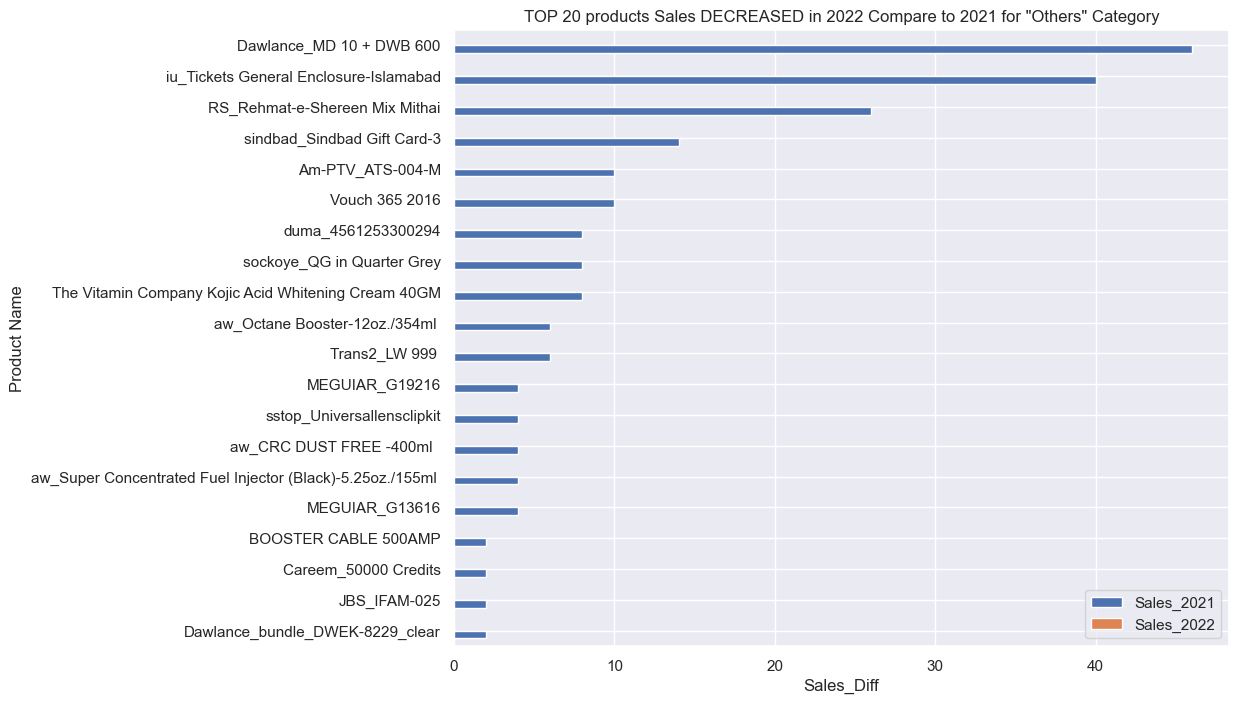

In [186]:
import matplotlib.pyplot as plt
# plot


Top_20_Products.sort_values(by='Sales_Diff', ascending=False, inplace=True)
sns.set()
Top_20_Products.plot(x='Product_Name',\
                      y=['Sales_2021','Sales_2022'],\
                      kind='barh',\
                      figsize=(10, 8))
plt.title('TOP 20 products Sales DECREASED in 2022 Compare to 2021 for "Others" Category')
plt.ylabel('Product Name')
plt.xlabel('Sales_Diff')

In [30]:
"""Question 3 Identifying Customers Who Completed Checkout but Didn't Pay in 2022 Scenario: 
The Digital Marketing Team wants to identify customers who completed the checkout process but did not make a payment in 2022.
 This will help them reach out for promotional purposes. 
Requirements: 
• Filter the data to find records where is_gross is 1 (indicating completed checkout process but did not make a payment)
• Retrieve the customer_id and registered_date for these records. 
• Ensure there are no duplicate customer_id entries. 
• Share the compiled data with the Marketing Team.
 Key Features to Use: • is_gross (for checkout status) • is_valid, is_net (to filter invalid or net transactions) 
 • order_date (for filtering by year) • customer_id • registered_dateckout but no payment), is_valid is 0, and is_net is 0, for the year 2022.
"""

"Question 3 Identifying Customers Who Completed Checkout but Didn't Pay in 2022 Scenario: \nThe Digital Marketing Team wants to identify customers who completed the checkout process but did not make a payment in 2022.\n This will help them reach out for promotional purposes. \nRequirements: \n• Filter the data to find records where is_gross is 1 (indicating completed checkout process but did not make a payment)\n• Retrieve the customer_id and registered_date for these records. \n• Ensure there are no duplicate customer_id entries. \n• Share the compiled data with the Marketing Team.\n Key Features to Use: • is_gross (for checkout status) • is_valid, is_net (to filter invalid or net transactions) \n • order_date (for filtering by year) • customer_id • registered_dateckout but no payment), is_valid is 0, and is_net is 0, for the year 2022.\n"

In [31]:
# define dataframe with filter as requested
cs_gross_data = (
    df.loc[
        (df['is_gross'] == 1) &
        (df['is_valid'] == 0) &
        (df['is_net'] == 0) &
        (df['order_date'].dt.year == 2022),
        ['customer_id', 'registered_date']
    ]
    .drop_duplicates(subset=['customer_id'])
    .reset_index(drop=True)
)
# show the data
cs_gross_data

,customer_id,registered_date
0,C993531L,2021-11-08
1,C652751L,2022-07-19
2,C189144L,2022-07-01
3,C224183L,2022-04-07
4,C907186L,2022-05-08
...,...,...
815,C118563L,2022-06-07
816,C217246L,2022-08-04
817,C577176L,2022-06-01
818,C744990L,2022-05-21


In [32]:
"""Question 4
Comparing Weekend and Weekday Sales in Q4 2022 Scenario: 
The Campaign Team wants to evaluate the effectiveness of their weekend promotional campaigns (Saturdays and Sundays)
 between October and December 2022 by comparing the average daily sales during weekends vs weekdays.
 Requirements: 1. Calculate the average daily sales (before_discount) for weekends (Saturdays and Sundays) and weekdays (Monday to Friday) 
 for each month (October, November, and December 2022).
 2. Calculate the average sales for weekends vs weekdays for the entire three-month period. 
 3. Share insights on whether sales increased during weekends.
 Key Features to Use: • order_date (for filtering by date and identifying days of the week)
 • before_discount (for sales data) • month_id, month_name, day_name, year (for extracting date-related information)
"""

'Question 4\nComparing Weekend and Weekday Sales in Q4 2022 Scenario: \nThe Campaign Team wants to evaluate the effectiveness of their weekend promotional campaigns (Saturdays and Sundays)\n between October and December 2022 by comparing the average daily sales during weekends vs weekdays.\n Requirements: 1. Calculate the average daily sales (before_discount) for weekends (Saturdays and Sundays) and weekdays (Monday to Friday) \n for each month (October, November, and December 2022).\n 2. Calculate the average sales for weekends vs weekdays for the entire three-month period. \n 3. Share insights on whether sales increased during weekends.\n Key Features to Use: • order_date (for filtering by date and identifying days of the week)\n • before_discount (for sales data) • month_id, month_name, day_name, year (for extracting date-related information)\n'

In [33]:
# add column month_id, month_name, day_name, year
df['month_id'] = df['order_date'].dt.month
df['month_name'] = df['order_date'].dt.month_name()
df['day_name'] = df['order_date'].dt.day_name()
df['year'] = df['order_date'].dt.year

In [34]:
# Create dataframe for weekends data October-December 2022
data_weekends = pd.DataFrame(\
                             # filter
                             df[(df['is_valid'] == 1) &\
                              (df['day_name'].isin(['Saturday', 'Sunday'])) &\
                              (df['month_id'] >= 10) &\
                               (df['year'] == 2022)]\
                             # groupby, aggregate before_discount
                             .groupby(by=['month_id', 'month_name', 'year'])['before_discount'].mean()\
                             # round
                             .round(2)\
                             # convert series to dataframe
                             .reset_index(name='avg_sales_weekends')\
                             .sort_values(by='month_id', ascending=True)
                             )

# Create dataframe for weekdays data October-December 2022
data_weekdays = pd.DataFrame(\
                             # filter
                             df[(df['is_valid'] == 1) &\
                              (df['day_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) &\
                              (df['month_id'] >= 10) &\
                               (df['year'] == 2022)]\
                             # groupby, aggregate before_discount
                             .groupby(by=['month_id', 'month_name', 'year'])['before_discount'].mean()\
                             # round
                             .round(2)\
                             # convert series to dataframe
                             .reset_index(name='avg_sales_weekdays')\
                             .sort_values(by='month_id', ascending=True)
                             )

# merge the dataframe
data_weekdays_weekends = data_weekdays.merge(data_weekends)

# show the data
data_weekdays_weekends

,month_id,month_name,year,avg_sales_weekdays,avg_sales_weekends
0,10,October,2022,885671.82,634260.0
1,11,November,2022,641861.93,607794.0
2,12,December,2022,813973.74,410599.4


In [35]:
# Filter dataframe df for weekends, October-December 2022
data_weekends_all = df[(df['is_valid'] == 1) &\
                    (df['day_name'].isin(['Saturday', 'Sunday'])) &\
                    (df['month_id'] >= 10) &\
                      (df['year'] == 2022)]

# Filter dataframe df for weekdays, October-December 2022
data_weekdays_all = df[(df['is_valid'] == 1) &\
                    (df['day_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) &\
                    (df['month_id'] >= 10) &\
                      (df['year'] == 2022)]

# Create dictionary
all_month_avg_compare = {\
                        'Period':'Total 3 months',\
                        'Avg Weekdays Sales': round(data_weekdays_all['before_discount'].mean(),2),\
                        'Avg Weekends Sales': round(data_weekends_all['before_discount'].mean(),2),\
                        'Diff (Value)': round(data_weekends_all['before_discount'].mean() - data_weekdays_all['before_discount'].mean(),2),\
                        'Diff (%)': pd.Series(round(((data_weekends_all['before_discount'].mean() - data_weekdays_all['before_discount'].mean())/data_weekends_all['before_discount'].mean())*100,2), dtype=str)+'%'
                        }

# create dataframe from dictionary
compare_avg_weekends_weekdays = pd.DataFrame(data=all_month_avg_compare, index=[0])

# show the data
compare_avg_weekends_weekdays

,Period,Avg Weekdays Sales,Avg Weekends Sales,Diff (Value),Diff (%)
0,Total 3 months,772341.0,558865.06,-213475.94,-38.2%


<Axes: xlabel='Period', ylabel='Average Sales'>

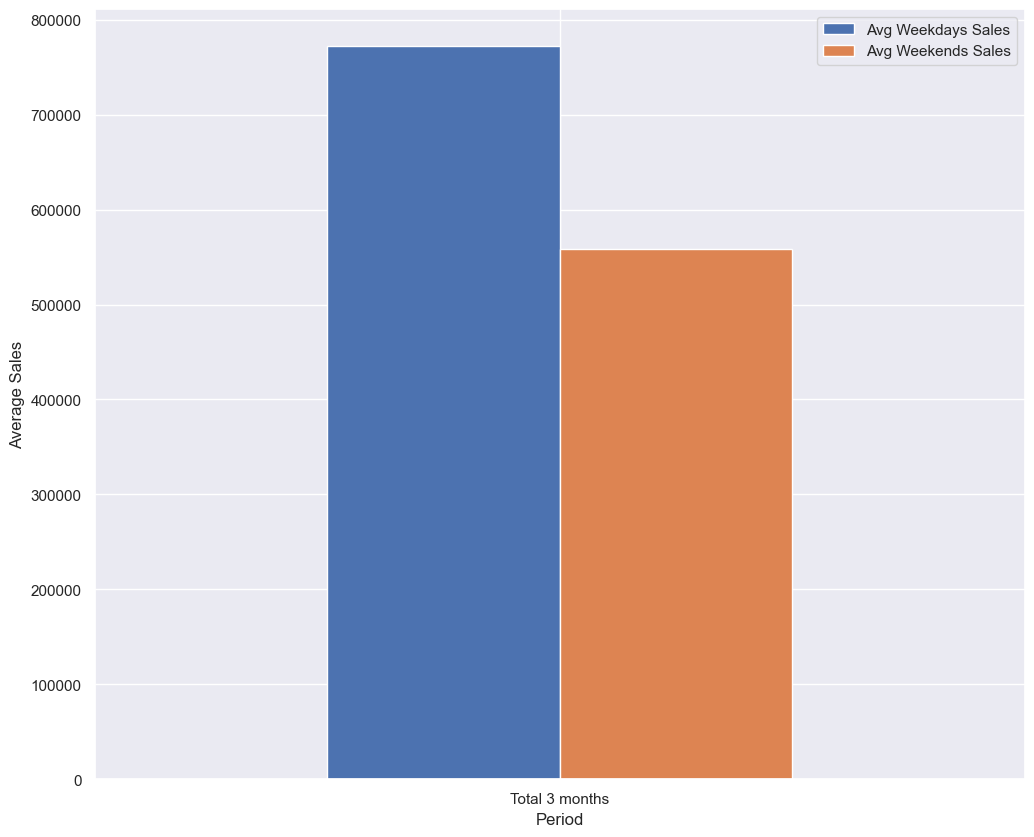

In [36]:
# plot the data
sns.set()
compare_avg_weekends_weekdays.plot(x='Period',
                                  y=['Avg Weekdays Sales','Avg Weekends Sales'],
                                  kind='bar',
                                  grid = True,
                                  # xlabel = 'Month Name',
                                  ylabel = 'Average Sales',
                                  figsize=(12,10),
                                  rot = 0,  # for rotate the text in xlabel
                                  table = False,
                                  secondary_y = False)

In [37]:
"""Question 5
Finding Products with the Largest Decrease in Sales Between Two Periods (e.g., 2022 vs 2021) Scenario:
 The Sales Team would like to identify which products had the most significant decrease in sales between two periods (e.g., 2021 and 2022). 
 Requirements: 1. Create two datasets for each period (e.g., 2021 and 2022), aggregated by product (sku_name). 
 2. Calculate the sales difference between the two periods.
 3. Identify the products with the largest decrease in sales and show the top 10 products. 
 4. Create a bar chart to visualize the products with the largest decrease in sales.
 Key Features to Use: • sku_name (for product names) • order_date (for filtering by year) • qty_ordered (for sales data)
"""

'Question 5\nFinding Products with the Largest Decrease in Sales Between Two Periods (e.g., 2022 vs 2021) Scenario:\n The Sales Team would like to identify which products had the most significant decrease in sales between two periods (e.g., 2021 and 2022). \n Requirements: 1. Create two datasets for each period (e.g., 2021 and 2022), aggregated by product (sku_name). \n 2. Calculate the sales difference between the two periods.\n 3. Identify the products with the largest decrease in sales and show the top 10 products. \n 4. Create a bar chart to visualize the products with the largest decrease in sales.\n Key Features to Use: • sku_name (for product names) • order_date (for filtering by year) • qty_ordered (for sales data)\n'

In [38]:
Sales_2021 = pd.DataFrame(\
                    
                         
                           # filter is_valid = 1 and year 2021
                          df[  (df['is_valid']==1) & (df['order_date'].dt.year == 2021)]\
                           # groupby quantity
                           .groupby(by=['sku_name','category'])['qty_ordered'].sum()\
                           # convert to dataframe
                           .reset_index(name='Sales_2021')
     .rename(columns={
                     'sku_name': 'Product_Name'})
     .sort_values(by='Sales_2021', ascending=False)\
                           )
Sales_2021

Sales_2022 = pd.DataFrame(\
                    
                         
                           # filter is_valid = 1 and year 2021
                          df[  (df['is_valid']==1) & (df['order_date'].dt.year == 2022)]\
                           # groupby quantity
                           .groupby(by=['sku_name','category'])['qty_ordered'].sum()\
                           # convert to dataframe
                           .reset_index(name='Sales_2022')
     .rename(columns={
                     'sku_name': 'Product_Name'})
     .sort_values(by='Sales_2022', ascending=False)\
                           )

Sales_2022.sort_values(by='Sales_2022', ascending=True, inplace=True)
Sales_2022

,Product_Name,category,Sales_2022
1380,stinnos_A102,Kids & Baby,2
262,Fantastic_FT-27,Health & Sports,2
263,Fantastic_FT-41,Home & Living,2
265,Fidato Ankle High Boot 309-872-40,Men Fashion,2
266,Fidato Ankle High Boot 309-872-42,Men Fashion,2
...,...,...,...
706,RS_Plain Rusk Pack of 3,Soghaat,196
682,RB_HouseholdBundle,Superstore,272
442,Jayqeu_BL-01-Red-M,Women Fashion,300
443,Jayqeu_BL-01-Red-S,Women Fashion,300


In [54]:
Sales_2021_2022 = Sales_2021.merge(Sales_2022[['Product_Name', 'Sales_2022']], how='inner')

# fill "NaN" with "Others" in column "category"
Sales_2021_2022['category'].fillna('Others', inplace=True)

# fill the rest "NaN" with 0
Sales_2021_2022.fillna(0, inplace=True)

Sales_2021_2022


C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_27588\2428691522.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Sales_2021_2022['category'].fillna('Others', inplace=True)


,Product_Name,category,Sales_2021,Sales_2022
0,RB_Dettol Germ Busting Kit-bf,Others,400,80
1,RS_Baklawa 500gm,Soghaat,214,36
2,jn_900g,Superstore,104,20
3,RS_Soan Papri-250gm,Soghaat,102,14
4,Topline_Waheed Murad His Life and Our Times,Books,82,20
...,...,...,...,...
161,s_tv_KLV-40R352C,Entertainment,2,4
162,HOS-W_VSBSIBEDP100,Beauty & Grooming,2,6
163,timex_T20501,Men Fashion,2,2
164,timex_T46681,Men Fashion,2,4


In [173]:
Sales_2021_2022['Sales_Diff'] = Sales_2021_2022['Sales_2022'] - Sales_2021_2022['Sales_2021']
Sales_2021_2022.sort_values(by='Sales_Diff', ascending=True, inplace=True)


Sales_2021_2022

,Product_Name,category,Sales_2021,Sales_2022,Sales_Diff
0,RB_Dettol Germ Busting Kit-bf,Others,400,80,-320
1,RS_Baklawa 500gm,Soghaat,214,36,-178
3,RS_Soan Papri-250gm,Soghaat,102,14,-88
2,jn_900g,Superstore,104,20,-84
4,Topline_Waheed Murad His Life and Our Times,Books,82,20,-62
...,...,...,...,...,...
102,PNG_Pampers_10003452-Hazir,Superstore,2,44,42
72,RS_Nimcolia-5pack,Soghaat,4,58,54
36,un_Green Tea Bundle_GT,Superstore,10,64,54
42,emart_Tyre Shape Air Compressor,Others,10,68,58


In [174]:
top_10_products = Sales_2021_2022.head(10)
top_10_products

,Product_Name,category,Sales_2021,Sales_2022,Sales_Diff
0,RB_Dettol Germ Busting Kit-bf,Others,400,80,-320
1,RS_Baklawa 500gm,Soghaat,214,36,-178
3,RS_Soan Papri-250gm,Soghaat,102,14,-88
2,jn_900g,Superstore,104,20,-84
4,Topline_Waheed Murad His Life and Our Times,Books,82,20,-62
7,Telemall_MM-DR-HB-L,Others,46,4,-42
5,RS_Kaju Barfi,Soghaat,58,20,-38
12,BB_bundle_bf,Superstore,34,2,-32
9,Al Muhafiz Sohan Halwa Cashew,Soghaat,40,12,-28
14,RS_Double Delight,Soghaat,28,4,-24


C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_27588\355368819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_products.sort_values(by='Sales_Diff', ascending=True, inplace=True)


<Axes: title={'center': 'TOP 5 Products'}, xlabel='Product Name', ylabel='Sales'>

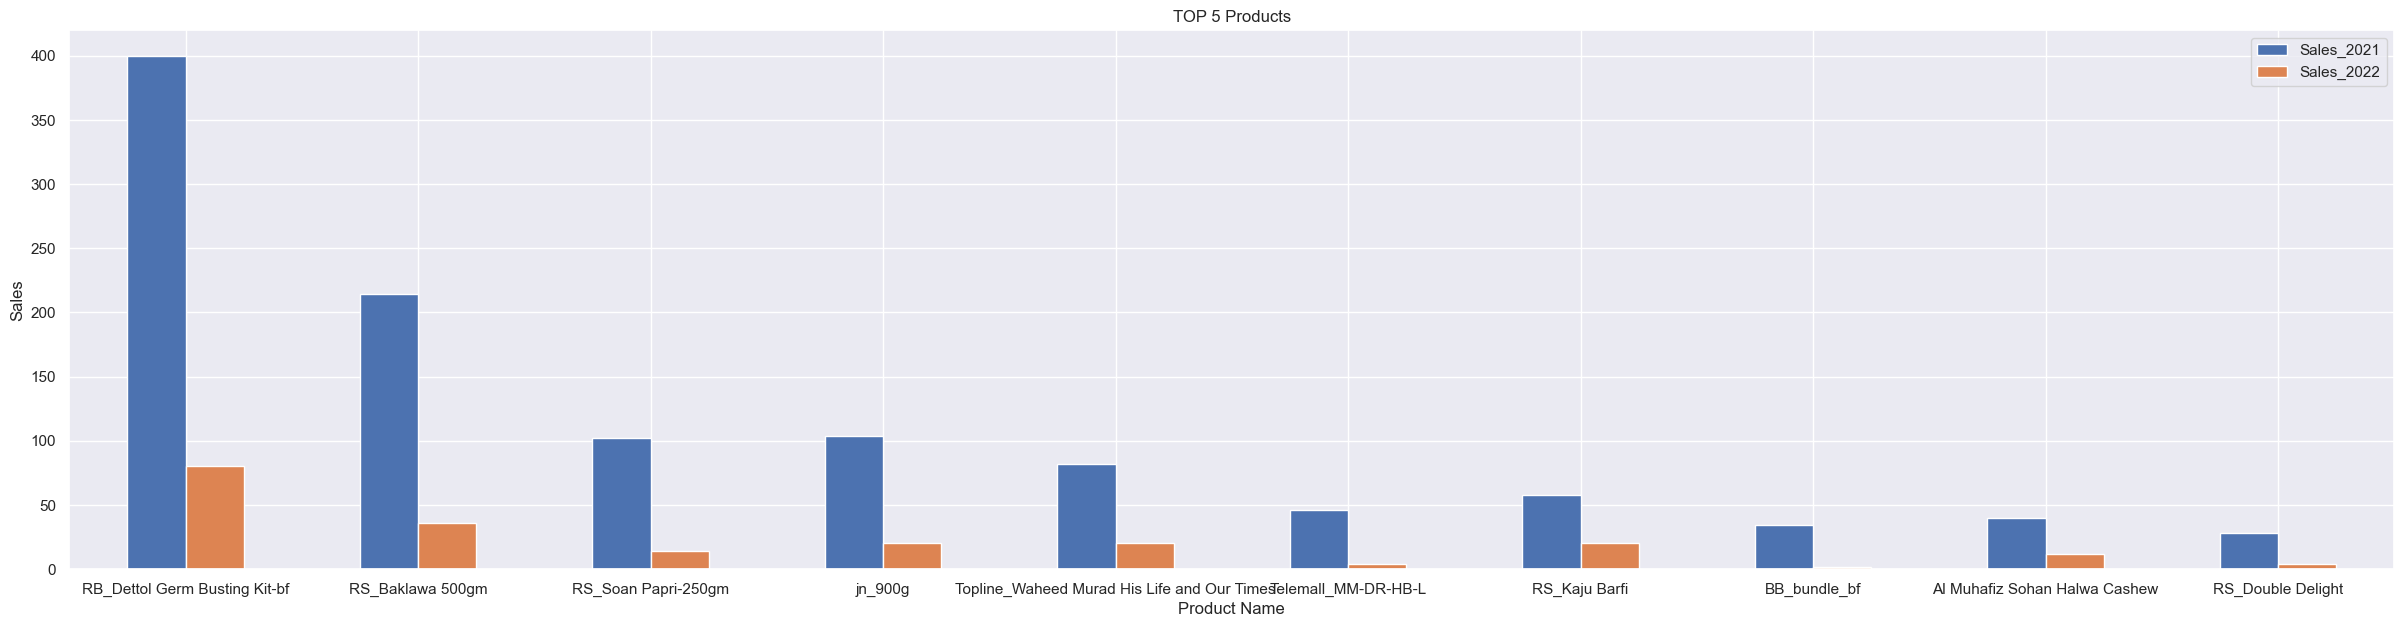

In [175]:

top_10_products.sort_values(by='Sales_Diff', ascending=True, inplace=True)

# plot

top_10_products.plot(x='Product_Name',
           y=['Sales_2021','Sales_2022'],
           kind='bar', # barh for horizontal bar chart
           grid = True,
           xlabel = 'Product Name',
           ylabel = 'Sales',
           figsize=(30,7),
           rot = 0,
           title = 'TOP 5 Products',
           table = False,
           secondary_y = False)





In [77]:
"""Question 6

Comparing Sales Trends for Multiple Categories in 2022 Scenario: 
The Marketing Team wants to compare the sales trends for multiple categories in 2022 to identify which category performed best. 
Requirements: 1. Aggregate the sales data by category for 2022.
 2. Plot a time series of sales trends for each category (use order_date to group by month or week). 
 3. Provide insights on which category had the highest sales growth. 
 Key Features to Use: • category • order_date (for time series analysis) • qty_ordered
 """

'Question 6\n\nComparing Sales Trends for Multiple Categories in 2022 Scenario: \nThe Marketing Team wants to compare the sales trends for multiple categories in 2022 to identify which category performed best. \nRequirements: 1. Aggregate the sales data by category for 2022.\n 2. Plot a time series of sales trends for each category (use order_date to group by month or week). \n 3. Provide insights on which category had the highest sales growth. \n Key Features to Use: • category • order_date (for time series analysis) • qty_ordered\n '

In [177]:
Sales_2022 = (
    df[
        (df['is_valid'] == 1) &
        (df['order_date'].dt.year == 2022)
    ]
    .groupby(by=['category'], as_index=False)['qty_ordered']
    .sum()
    .rename(columns={'qty_ordered': 'Sales_2022'})
    .sort_values(by='Sales_2022', ascending=False)
    .reset_index(drop=True)
)
Sales_2022

,category,Sales_2022
0,Mobiles & Tablets,2306
1,Soghaat,1214
2,Superstore,1072
3,Women Fashion,962
4,Others,508
5,Home & Living,498
6,School & Education,470
7,Kids & Baby,448
8,Health & Sports,394
9,Books,390


In [124]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df_2022 = df[(df['is_valid'] == 1) & (df['order_date'].dt.year == 2022)].copy()
df_2022 = df[(df['is_valid'] == 1) & (df['order_date'].dt.year == 2022)]


In [126]:
sales_trend = (
    df_2022
    .set_index('order_date')
    .groupby([pd.Grouper(freq='M'), 'category'])['qty_ordered']
    .sum()
    .reset_index()
)

C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_27588\3457051012.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'category'])['qty_ordered']


In [127]:
sales_pivot = sales_trend.pivot(index='order_date', columns='category', values='qty_ordered').fillna(0)


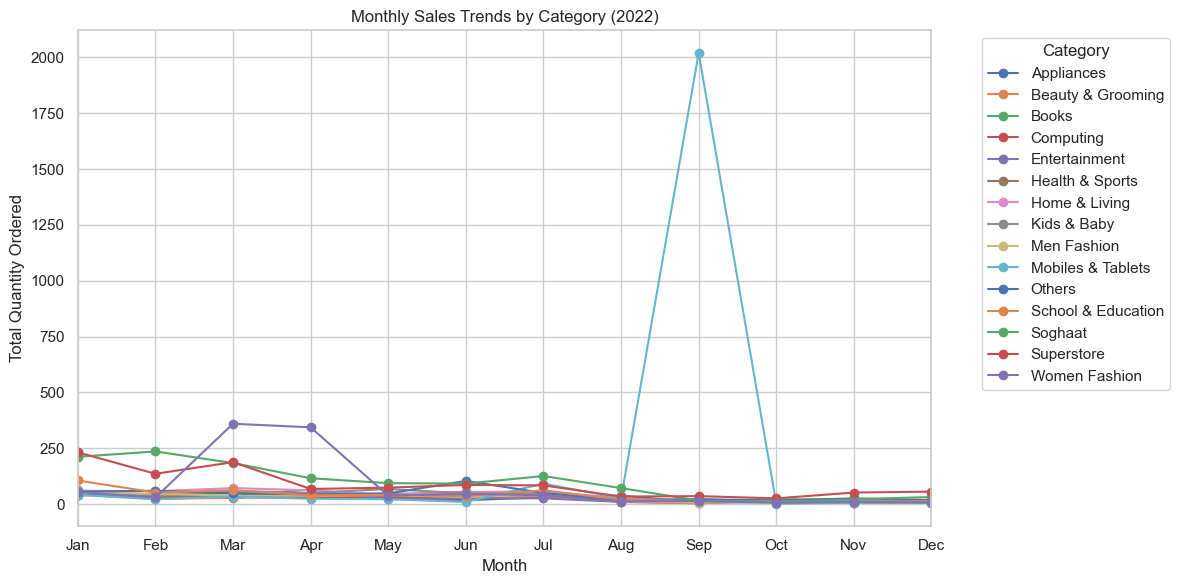

In [131]:
sns.set(style="whitegrid")
sales_pivot.plot(kind='line', figsize=(12, 6), marker='o')

plt.title('Monthly Sales Trends by Category (2022)')
plt.xlabel('Month')
plt.ylabel('Total Quantity Ordered')
plt.xticks(sales_pivot.index, [d.strftime('%b') for d in sales_pivot.index], rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [154]:
#Task 1
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_5_products.csv"  # Update with your desired folder path

# Save to CSV
Top_5_products.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_5_products.csv


In [172]:
#Task 2
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_20_Products.csv"  # Update with your desired folder path

# Save to CSV
Top_20_Products.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_20_Products.csv


In [179]:
#Task 4
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\compare_avg_weekends_weekdays.csv"  # Update with your desired folder path

# Save to CSV
compare_avg_weekends_weekdays.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\compare_avg_weekends_weekdays.csv


In [176]:

#Task 5
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_10_Products.csv"  # Update with your desired folder path

# Save to CSV
top_10_products.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_10_Products.csv


In [178]:
#Task 6
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Sales_2022.csv"  # Update with your desired folder path

# Save to CSV
Sales_2022.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Sales_2022.csv
